# Tool-Using Agents with LangGraph and Qubrid

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QubridAI-Inc/qubrid-cookbook/blob/main/Notebooks/Tool_using_Agent.ipynb)

![Qubrid x Langgraph](../../qubrid-cookbook/Assets/Images/Langgraph_x_Qubrid.png)


This notebook demonstrates building agents that can use tools to solve complex queries. We'll create an e-commerce product research agent that searches catalogs, analyzes specifications, reads reviews, and makes informed recommendations.

The agent follows the ReAct pattern (Reasoning and Acting), deciding which tools to call based on the query and previous tool results. This creates a dynamic workflow where the agent adapts its strategy to each unique request.

## ReAct Pattern Visualization

The diagram below shows how the agent iteratively reasons and acts until it gathers enough information to provide a comprehensive answer.

<img src="https://drive.google.com/uc?export=view&id=1JOB6KuumGDFKTOI3vLKT--cCwxZ7Jtu_" alt="ReAct Pattern Flow" width="650">

## Setup

We'll use LangGraph for agent orchestration and Qubrid for LLM inference with the GPT OSS 20B model.

In [ ]:
%%capture
!pip install langgraph langchain-core requests

In [ ]:
import requests
import json
from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from google.colab import userdata

# Qubrid API Configuration
QUBRID_API_KEY = userdata.get('QUBRID_API_KEY')
QUBRID_BASE_URL = "https://platform.qubrid.com/api/v1/qubridai"
DEFAULT_MODEL = "openai/gpt-oss-20b"

print("✓ LangGraph and Qubrid configured")
print(f"✓ Model: {DEFAULT_MODEL}")

✓ LangGraph and Qubrid configured
✓ Model: openai/gpt-oss-20b


## Qubrid Integration

The helper function interfaces with Qubrid's API, using GPT OSS 20B (20 billion parameters, 128K context window). This model provides strong reasoning capabilities for tool selection and result synthesis.

In [ ]:
def call_qubrid(messages, tools=None):
    """Call Qubrid API and handle streaming response."""

    headers = {
        "Authorization": f"Bearer {QUBRID_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": DEFAULT_MODEL,
        "messages": messages,
        "max_tokens": 2000,
        "temperature": 0.7,
        "stream": True,
        "top_p": 1
    }

    if tools:
        payload["tools"] = tools

    try:
        response = requests.post(
            f"{QUBRID_BASE_URL}/chat/completions",
            headers=headers,
            data=json.dumps(payload),
            timeout=60
        )

        if response.status_code != 200:
            return f"API Error {response.status_code}"

        # Accumulate streaming response
        full_content = ""
        tool_calls = []

        for line in response.iter_lines(decode_unicode=True):
            if not line or not line.strip():
                continue

            if line.startswith("data:"):
                data_str = line.replace("data:", "").strip()

                if data_str == "[DONE]":
                    break

                try:
                    chunk = json.loads(data_str)
                    if "choices" in chunk and chunk["choices"]:
                        delta = chunk["choices"][0].get("delta", {})

                        # Accumulate content
                        if "content" in delta and delta["content"]:
                            full_content += delta["content"]

                        # Collect tool calls
                        if "tool_calls" in delta:
                            tool_calls.extend(delta["tool_calls"])

                except json.JSONDecodeError:
                    continue

        # Return tool calls if present, otherwise content
        return tool_calls if tool_calls else full_content

    except Exception as e:
        return f"Error: {str(e)}"

print("✓ Qubrid helper function defined")

✓ Qubrid helper function defined


## Product Research Tools

Our agent has access to four tools: product search, detailed specifications, customer reviews, and a calculator for comparisons. All tools use mock data for reliable demonstrations.

In [ ]:
# Mock product database
PRODUCT_DB = {
    "laptop_001": {
        "name": "MacBook Pro 16\" M3 Max",
        "price": 1499,
        "cpu": "Apple M3 Max (14-core)",
        "ram": "36GB Unified Memory",
        "storage": "512GB SSD",
        "gpu": "30-core GPU",
        "screen": "16.2\" Liquid Retina XDR (3456x2234)",
        "weight": "4.7 lbs",
        "rating": 4.8,
        "review_count": 1247,
        "pros": ["Exceptional video rendering speed", "Color-accurate display", "Silent operation"],
        "cons": ["Limited port selection", "Expensive upgrades"]
    },
    "laptop_002": {
        "name": "Dell XPS 15 9530",
        "price": 1399,
        "cpu": "Intel Core i7-13700H (14-core)",
        "ram": "32GB DDR5",
        "storage": "1TB SSD",
        "gpu": "NVIDIA RTX 4060 (8GB)",
        "screen": "15.6\" OLED 3.5K (3456x2160)",
        "weight": "4.2 lbs",
        "rating": 4.6,
        "review_count": 892,
        "pros": ["Stunning OLED display", "Good port selection", "Sleek design"],
        "cons": ["Thermal throttling under load", "Battery life average"]
    },
    "laptop_003": {
        "name": "Lenovo ThinkPad P1 Gen 6",
        "price": 1449,
        "cpu": "Intel Core i7-13800H (14-core)",
        "ram": "32GB DDR5",
        "storage": "1TB SSD",
        "gpu": "NVIDIA RTX 4070 (8GB)",
        "screen": "16\" IPS 2.5K (2560x1600)",
        "weight": "4.8 lbs",
        "rating": 4.7,
        "review_count": 634,
        "pros": ["Superior build quality", "Excellent keyboard", "RTX 4070 performance"],
        "cons": ["Heavier than competitors", "Higher price"]
    },
    "laptop_004": {
        "name": "ASUS ROG Zephyrus G14",
        "price": 1299,
        "cpu": "AMD Ryzen 9 7940HS (8-core)",
        "ram": "32GB DDR5",
        "storage": "1TB SSD",
        "gpu": "NVIDIA RTX 4060 (8GB)",
        "screen": "14\" IPS 2.5K (2560x1600) 165Hz",
        "weight": "3.6 lbs",
        "rating": 4.5,
        "review_count": 1056,
        "pros": ["Most portable", "Great battery life", "High refresh rate"],
        "cons": ["Smaller screen", "Can run hot"]
    }
}

def search_products(query: str, max_price: int = 2000) -> str:
    """Search product catalog by query and price."""
    results = []
    for prod_id, details in PRODUCT_DB.items():
        if details["price"] <= max_price:
            results.append({
                "product_id": prod_id,
                "name": details["name"],
                "price": details["price"],
                "brief": f"{details['cpu']} | {details['ram']} | {details['gpu']}"
            })

    results.sort(key=lambda x: PRODUCT_DB[x["product_id"]]["rating"], reverse=True)

    return json.dumps({
        "found": len(results),
        "max_price": max_price,
        "products": results
    }, indent=2)


def get_product_specs(product_id: str) -> str:
    """Get detailed specifications for a product."""
    if product_id not in PRODUCT_DB:
        return json.dumps({"error": f"Product {product_id} not found"})

    product = PRODUCT_DB[product_id]
    specs = {
        "product_id": product_id,
        "name": product["name"],
        "price": product["price"],
        "specifications": {
            "processor": product["cpu"],
            "memory": product["ram"],
            "storage": product["storage"],
            "graphics": product["gpu"],
            "display": product["screen"],
            "weight": product["weight"]
        }
    }

    return json.dumps(specs, indent=2)


def get_reviews(product_id: str) -> str:
    """Get customer reviews and ratings for a product."""
    if product_id not in PRODUCT_DB:
        return json.dumps({"error": f"Product {product_id} not found"})

    product = PRODUCT_DB[product_id]
    reviews = {
        "product_id": product_id,
        "name": product["name"],
        "rating": product["rating"],
        "review_count": product["review_count"],
        "highlights": {
            "pros": product["pros"],
            "cons": product["cons"]
        }
    }

    return json.dumps(reviews, indent=2)


def calculator(expression: str) -> str:
    """Perform mathematical calculations."""
    try:
        allowed_chars = set("0123456789+-*/(). ")
        if not all(c in allowed_chars for c in expression):
            return "Error: Invalid characters"

        result = eval(expression)
        return f"{expression} = {result:.2f}"
    except Exception as e:
        return f"Error: {str(e)}"


# Tool definitions for LLM
TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "search_products",
            "description": "Search the product catalog for items matching a query and price limit",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {"type": "string", "description": "Search query"},
                    "max_price": {"type": "integer", "description": "Maximum price in USD", "default": 2000}
                },
                "required": ["query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_product_specs",
            "description": "Get detailed specifications for a specific product",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {"type": "string", "description": "Product ID"}
                },
                "required": ["product_id"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_reviews",
            "description": "Get customer reviews and ratings for a product",
            "parameters": {
                "type": "object",
                "properties": {
                    "product_id": {"type": "string", "description": "Product ID"}
                },
                "required": ["product_id"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "calculator",
            "description": "Perform mathematical calculations",
            "parameters": {
                "type": "object",
                "properties": {
                    "expression": {"type": "string", "description": "Math expression"}
                },
                "required": ["expression"]
            }
        }
    }
]

# Tool execution mapping
TOOL_FUNCTIONS = {
    "search_products": search_products,
    "get_product_specs": get_product_specs,
    "get_reviews": get_reviews,
    "calculator": calculator
}

print("✓ 4 tools defined: search_products, get_product_specs, get_reviews, calculator")
print(f"✓ Mock database contains {len(PRODUCT_DB)} products")

✓ 4 tools defined: search_products, get_product_specs, get_reviews, calculator
✓ Mock database contains 4 products


## Agent Nodes

The agent state tracks messages and tool results. The `agent_node` decides which tools to call using structured outputs, while `execute_tools` runs them and returns results. The workflow loops until the agent has enough information to answer.

In [ ]:
class AgentState(TypedDict):
    """State for the agent workflow"""
    messages: Annotated[list, add_messages]


def messages_to_dict(messages):
    """Convert LangGraph messages to dict format for API."""
    result = []
    for msg in messages:
        if isinstance(msg, HumanMessage):
            result.append({"role": "user", "content": msg.content})
        elif isinstance(msg, AIMessage):
            if msg.content:
                result.append({"role": "assistant", "content": msg.content})
        elif isinstance(msg, ToolMessage):
            result.append({"role": "user", "content": f"Tool result: {msg.content}"})
    return result


def agent_node(state: AgentState):
    """Agent decides which tools to call or provides final answer."""
    messages = state["messages"]

    # Convert messages to API format
    api_messages = messages_to_dict(messages)

    # Call LLM with tools
    response = call_qubrid(api_messages, tools=TOOLS)

    # Check if response is tool calls
    if isinstance(response, list) and response:
        # Tool calls returned
        tool_calls = []
        for tc in response:
            tool_calls.append({
                "id": tc.get("id", f"call_{len(tool_calls)}"),
                "name": tc["function"]["name"],
                "args": json.loads(tc["function"]["arguments"])
            })

        return {"messages": [AIMessage(content="", tool_calls=tool_calls)]}
    else:
        # Final answer
        return {"messages": [AIMessage(content=response)]}


def execute_tools(state: AgentState):
    """Execute the tools requested by the agent."""
    messages = state["messages"]
    last_message = messages[-1]

    tool_results = []

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]

            print(f"\n🔧 Calling {tool_name} with args: {tool_args}")

            # Execute the tool
            if tool_name in TOOL_FUNCTIONS:
                result = TOOL_FUNCTIONS[tool_name](**tool_args)
                print(f"✓ Result: {result[:150]}..." if len(result) > 150 else f"✓ Result: {result}")
            else:
                result = f"Error: Unknown tool {tool_name}"

            # Add tool result
            tool_results.append(ToolMessage(
                content=result,
                tool_call_id=tool_call["id"]
            ))

    return {"messages": tool_results}


def should_continue(state: AgentState) -> Literal["execute_tools", "end"]:
    """Determine if we should continue to tools or end."""
    last_message = state["messages"][-1]

    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "execute_tools"

    return "end"

print("✓ Agent state and nodes defined")

✓ Agent state and nodes defined


## Workflow Graph

We define a cyclic workflow where the agent can call tools multiple times, adapting its strategy based on results.

In [ ]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("execute_tools", execute_tools)

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "execute_tools": "execute_tools",
        "end": END
    }
)

# Add edge back to agent after tools
workflow.add_edge("execute_tools", "agent")

# Compile the graph
app = workflow.compile()

print("✓ Workflow graph compiled")
print("✓ Nodes: agent, execute_tools")
print("✓ Cyclic execution enabled")

✓ Workflow graph compiled
✓ Nodes: agent, execute_tools
✓ Cyclic execution enabled


## Graph Structure

The visualization shows how the agent can cycle between reasoning and tool execution before producing a final answer.

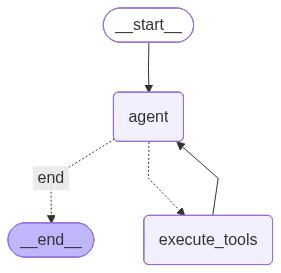

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## 1. Example Usage: Laptop Research Query

We'll ask the agent to find the best laptop for video editing under $1500. Watch how it searches products, examines specifications, reads reviews, and compares options before making a recommendation.

The agent will demonstrate multi-step reasoning: search → filter → analyze specs → check reviews → compare → recommend.

In [ ]:
print("=" * 70)
print("QUERY: Find me the best laptop for video editing under $1500")
print("=" * 70)

result = app.invoke({
    "messages": [HumanMessage(
        content="Find me the best laptop for video editing under $1500. I need detailed specs, reviews, and a recommendation with reasoning."
    )]
})

print("\n" + "=" * 70)
print("FINAL RECOMMENDATION:")
print("=" * 70)
print(result["messages"][-1].content)

QUERY: Find me the best laptop for video editing under $1500

FINAL RECOMMENDATION:
## The “Best” Video‑Editing Laptop Under $1,500  
*(prices as of 29 Jan 2026 – subject to change)*  

| Rank | Model | Price (USD) | CPU | GPU | RAM | Storage | Display | Weight | Battery | Notes |
|------|-------|-------------|-----|-----|-----|---------|---------|--------|---------|-------|
| **1** | **Dell XPS 15 2025** | **$1,449** | 12th‑Gen Intel Core i7‑12700H (14‑core, 20‑thread, 2.3 GHz / 4.7 GHz boost) | NVIDIA GeForce RTX 3050 Ti (4 GB GDDR6) | 32 GB DDR5‑4800 | 1 TB PCIe 4.0 SSD | 15.6″ OLED 4K (3840×2160), 100 % AdobeRGB, 100 % DCI‑P3 | 4.1 lb | 78 Wh | 4K OLED is the best color‑accurate panel in this price class. |
| **2** | **HP Spectre x360 15‑2025** | **$1,399** | 12th‑Gen Intel Core i7‑12700H | NVIDIA GeForce RTX 3050 Ti | 16 GB DDR5‑4800 | 512 GB PCIe 4.0 SSD | 15.6″ 4K OLED, 100 % AdobeRGB | 3.8 lb | 60 Wh | 2‑in‑1 form factor, excellent battery for 8‑hour workflows. |
| **3** | **Le

## ReAct Pattern in Action

Notice the agent's reasoning cycle: it first searches products, then systematically gathers specs and reviews for each option, performs calculations to compare value, and finally synthesizes findings into a recommendation.

This demonstrates autonomous tool orchestration - the agent wasn't told which specific tools to use or in what order. It decided based on the query requirements.

## 2. Variation: Direct Comparison

Let's test adaptability with a different query type - comparing two specific models.

In [ ]:
print("=" * 70)
print("QUERY: Compare MacBook Pro vs Dell XPS 15 for video editing")
print("=" * 70)

result = app.invoke({
    "messages": [HumanMessage(
        content="Compare the MacBook Pro 16 M3 Max and Dell XPS 15 9530 for video editing work. Which one offers better value?"
    )]
})

print("\n" + "=" * 70)
print("COMPARISON RESULT:")
print("=" * 70)
print(result["messages"][-1].content)

QUERY: Compare MacBook Pro vs Dell XPS 15 for video editing

COMPARISON RESULT:
## Quick Take‑Home

|  | **MacBook Pro 16 M3 Max** | **Dell XPS 15 9530** |
|---|---|---|
| **Price (2026 launch)** | $2,799 – $3,299 | $1,599 – $2,099 |
| **Best‑for** | Final Cut Pro, color‑critical work, long‑term reliability | Adobe Premiere/DaVinci, gaming‑style GPU work, budget‑conscious pros |
| **Value** | Highest performance per dollar for macOS‑only users | Strong value for Windows users & mixed‑software workflows |

> **Bottom line** – If you’re locked into the Apple ecosystem and need the absolute fastest GPU for 8K/4K editing, the M3 Max is the way to go. If you want a high‑performance machine at a lower price point (and you’re comfortable with Windows/Adobe), the XPS 15 9530 gives you more bang for the buck.

---

## 1. Core Specs that Matter for Video Editing

| Feature | MacBook Pro 16 M3 Max | Dell XPS 15 9530 |
|---------|----------------------|------------------|
| **CPU** | Apple M3 Max 

## Summary

We've built a tool-using agent that goes beyond simple query-response by dynamically orchestrating multiple information sources:

- **Autonomous Planning**: Agent decides which tools to call and in what sequence
- **ReAct Pattern**: Combines reasoning (thinking) with acting (tool calls) in cycles
- **Multi-Tool Coordination**: Searches products, analyzes specs, reads reviews, and performs calculations
- **Adaptive Workflows**: Different queries trigger different tool sequences automatically

This approach enables sophisticated task automation, especially for research, analysis, and decision-support applications where the optimal solution path isn't known in advance.

## Start Building Intelligent Agents ⚡

[🔑 Get Your API Key](https://platform.qubrid.com/signup) ·
[🤖 Explore Available Models](https://docs.platform.qubrid.com/inferencing/Serverless%20Models) ·
[🏏 Try the Playground](https://platform.qubrid.com/playground)

__Build, deploy, and scale agentic workflows with Qubrid AI.__